**Importing Libraries**

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root = 'data/',train=True,transform=ToTensor())

In [3]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size = 128
train_loder = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)

Let's visualize a batch of data in a grid using the ```make_grid``` function from ```torchvision```. We'll also use the ```.permute``` method on the tensor to move the channels to the last dimension, as expected by ```matplotlib```.

Images Shape: torch.Size([128, 1, 28, 28])


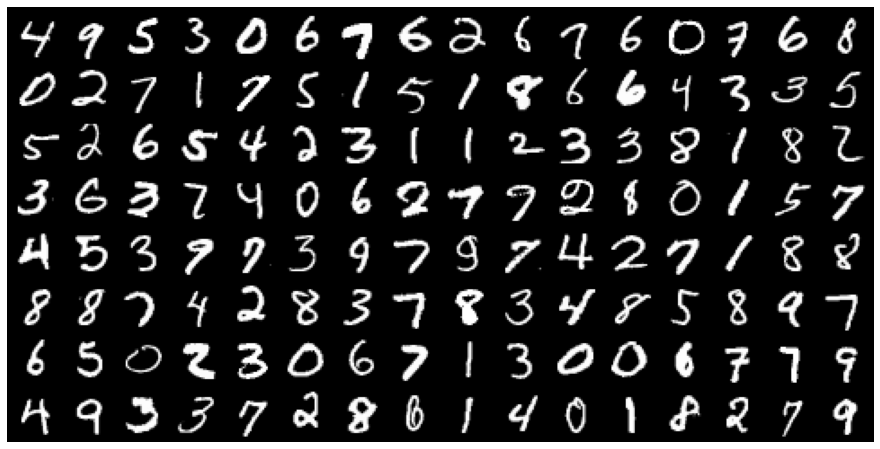

In [5]:
for images,_ in train_loder:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

## Model 

To improve upon logistic regression, we'll create a neural network with one hidden layer. Here's what this means:

* Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.

* The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size, where hidden_size is a preconfigured parameter (e.g. 32 or 64).

* The intermediate outputs are then passed into a non-linear activation function, which operates on individual elements of the output matrix.

* The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size batch_size x 10, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. Here's what it looks like visually:

![image](https://i.imgur.com/vDOGEkG.png)

The activation function we'll use here is called a ***Rectified Linear Unit or ReLU***, and it has a really simple formula: ```relu(x) = max(0,x)``` i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

To define the model, we extend the ```nn.Module``` class, just as we did with logistic regression.



In [6]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim = 1) ## _ here max prob will come and we don't require it now
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [7]:
class MnistModel(nn.Module):
    def __init__(self,input_size,hidden_size,out_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
    def forward(self,xb):
        xb = xb.view(xb.size(0),-1) ## same as .reshape()
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [8]:
input_size = 784
num_classes = 10

model = MnistModel(input_size,hidden_size = 32,out_size = num_classes)

In [9]:
model.parameters

<bound method Module.parameters of MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)>

## Using GPU

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using ```torch.cuda.is_available```.

In [10]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [12]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [13]:
def to_device(data,device):
    if isinstance(data, (list,tuple)): #The isinstance() function returns True if the specified object is of the specified type, otherwise False.
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

In [14]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        return len(self.dl)

The ```yield``` statement suspends function’s execution and sends a value back to the caller,
but retains enough state to enable function to resume where it is left off.
When resumed, the function continues execution immediately after the last yield run.
This allows its code to produce a series of values over time,rather than computing them at once and sending them back 
like a list.

We can now wrap our data loaders using ```DeviceDataLoader```.

In [15]:
train_loder = DeviceDataLoader(train_loder,device)
val_loader = DeviceDataLoader(val_loader,device)

## Train The Model

In [16]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [17]:
def fit(epochs,lr,model,train_loder,val_loader,opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        for batch in train_loder:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()#used to update the parameters
            optimizer.zero_grad()#Clears the gradients of  optimizer
        result = evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [18]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [19]:
evaluate(model,val_loader)

{'val_loss': 2.3173673152923584, 'val_acc': 0.08643196523189545}

In [20]:
history = fit(10,0.5,model,train_loder,val_loader)

Epoch [1], val_loss: 0.2402, val_acc: 0.9270
Epoch [2], val_loss: 0.1928, val_acc: 0.9422
Epoch [3], val_loss: 0.1612, val_acc: 0.9507
Epoch [4], val_loss: 0.1465, val_acc: 0.9572
Epoch [5], val_loss: 0.1318, val_acc: 0.9611
Epoch [6], val_loss: 0.1415, val_acc: 0.9593
Epoch [7], val_loss: 0.1209, val_acc: 0.9643
Epoch [8], val_loss: 0.1594, val_acc: 0.9541
Epoch [9], val_loss: 0.1481, val_acc: 0.9569
Epoch [10], val_loss: 0.1231, val_acc: 0.9671


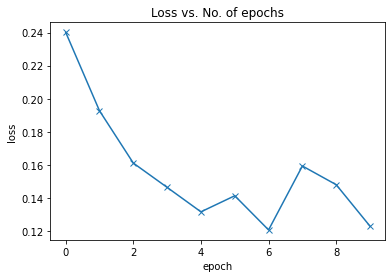

In [21]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

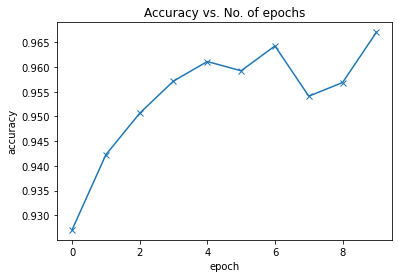

In [22]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');